In [1]:
import os
import cv2
import torch 
import numpy as np
import onnxruntime as ort

from models import Unet

from preprocessing import (
    subsample_point_cloud, 
    create_digital_elevation_model,
    pad_multiplo,
    create_input)

from postprocessing import(
    get_binary_img,
    get_componets,
    get_segments,
    get_measurement,
    get_coords,
    check_pretil
)

class PretilNet:
    def __init__(self, weights="model.pth", device='cuda'):
        self.model = Unet()
        self.model.load_state_dict(torch.load(weights))
        self.device = device
        self.model.eval()
        if device == 'cuda':
            self.model.cuda()



    def __call__(self, las_file, kmz_pretil, factor_size=0.1):
        ## Preprocessing
        dem_info = self.__preprocessing(las_file, factor_size)
        input = create_input(dem_info['dem']).astype(np.float32)
        input = torch.tensor(input, dtype=torch.float32, device=self.device)
        
        ## IA
        print(torch.min(input), torch.max(input))
        outputs = self.model(input)  # Returns a list of tensors.
        
        return outputs
        ## Posprocessing
        data_pixel = self.__postprocessing(outputs, dem_info['mask'], )
        data_coords = get_coords(data_pixel, dem_info)
        results = check_pretil(kmz_pretil, data_coords)
        return results
    
    def __preprocessing(self, input_file, factor_size):
        las = subsample_point_cloud(input_file, factor=factor_size)
        dem_info = create_digital_elevation_model(las.x,las.y,las.z) 
        dem_info['dem'], dem_info['mask'] = pad_multiplo(dem_info['dem'], dem_info['mask'])
        return dem_info

    def __postprocessing(self, outputs, mask):
        mask = np.expand_dims(mask, -1)
        outputs = [o.detach().cpu().numpy() for o in outputs]
        outputs = [o[0,:,:,:].transpose(1, 2, 0) * mask for o in outputs]
        
        img_class = outputs[0]
        img_pretil = outputs[1]

        print(img_class.shape, img_pretil.shape)
        
        binary_img = get_binary_img(img_class)
        valid_components, labels = get_componets(binary_img)
        segments = get_segments(valid_components, labels)
        binary_mask = binary_img.astype(bool)
        results = get_measurement(segments, binary_mask, img_pretil)

        return results


In [2]:
import numpy as np

model = PretilNet(weights="weigths/model_epoch_80.pth")

path_las = '../data/reduced_Inspecciones_Aéreas_Cámara_L2_Lidar_1.las'
path_kmz = 'Primer_Anillo_Aeropuerto.kmz'

outputs = model(path_las, path_kmz, factor_size=1)
print(outputs)

tensor(-14.2266, device='cuda:0') tensor(13.3157, device='cuda:0')
(tensor([[[[9.9996e-01, 9.9998e-01, 9.9998e-01,  ..., 1.0000e+00,
           1.0000e+00, 9.9992e-01],
          [9.9998e-01, 9.9999e-01, 9.9999e-01,  ..., 1.0000e+00,
           1.0000e+00, 1.0000e+00],
          [9.9998e-01, 9.9999e-01, 9.9999e-01,  ..., 1.0000e+00,
           1.0000e+00, 1.0000e+00],
          ...,
          [1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 1.0000e+00,
           1.0000e+00, 9.9996e-01],
          [9.9999e-01, 1.0000e+00, 1.0000e+00,  ..., 1.0000e+00,
           1.0000e+00, 9.9992e-01],
          [9.9908e-01, 9.9941e-01, 9.9958e-01,  ..., 9.9993e-01,
           9.9986e-01, 9.9863e-01]],

         [[1.9081e-05, 1.1442e-05, 9.6497e-06,  ..., 7.6420e-12,
           1.9122e-09, 1.2151e-06],
          [1.2295e-05, 6.1475e-06, 6.1099e-06,  ..., 7.3593e-15,
           2.7301e-10, 2.7007e-08],
          [1.1270e-05, 6.9555e-06, 5.8752e-06,  ..., 4.6703e-14,
           3.7106e-09, 9.8326e-08],
      

(1984, 1472, 3) (1984, 1472, 1)


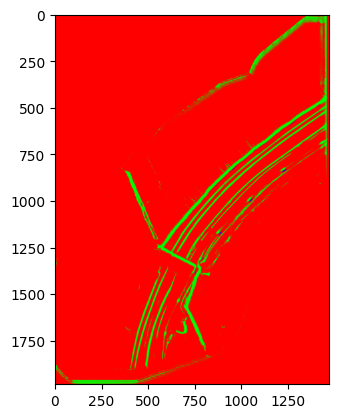

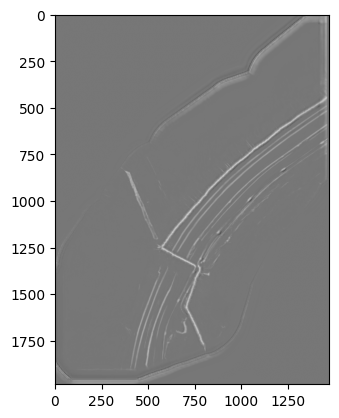

In [3]:
import matplotlib.pyplot as plt
#mask = dem_info['mask']
#mask = np.expand_dims(mask, -1)
o = [o.detach().cpu().numpy()[0,:,:,:].transpose(1, 2, 0) for o in outputs]
        
o1 = o[0] 
o1 = (np.clip(o1,0,1)*255).astype(np.uint8)
o2 = o[1]
print(o1.shape, o2.shape)

plt.imshow(o1) 
plt.show()
plt.imshow(o2, cmap='gray') 
plt.show()